In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
%cd drive/MyDrive/Colab Notebooks/disaster_tweets

/content/drive/MyDrive/Colab Notebooks/disaster_tweets


## <b> 1. Import Libraries

## <b> 2. Download Data 

In [7]:
import pandas as pd

In [9]:
tweet = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
submission = pd.read_csv('data/sample_submission.csv')

In [10]:
print('There are {} rows and {} columns in train'.format(tweet.shape[0],tweet.shape[1]))
print('There are {} rows and {} columns in test'.format(test.shape[0],test.shape[1]))

There are 7613 rows and 5 columns in train
There are 3263 rows and 4 columns in test


In [11]:
tweet.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


# <b> 3. EDA </b>

Thanks to:
* https://www.kaggle.com/vbmokin/nlp-eda-bag-of-words-tf-idf-glove-bert/

<b> Class Distribution </b>

Before we begin with anything else, let's check the class distribution.

In [12]:
# extracting the number of examples of each class
Real_len = tweet[tweet['target'] == 1].shape[0]
Not_len = tweet[tweet['target'] == 0].shape[0]

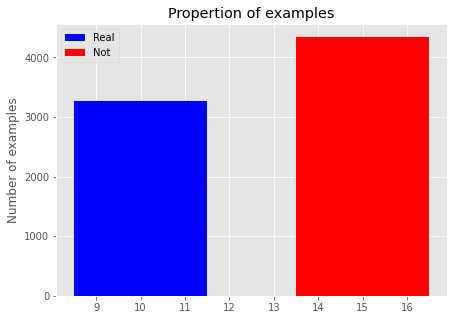

In [13]:
# bar plot of the 3 classes
plt.rcParams['figure.figsize'] = (7, 5)
plt.bar(10, Real_len, 3, label="Real", color='blue')
plt.bar(15, Not_len, 3, label="Not", color='red')
plt.legend()
plt.ylabel('Number of examples')
plt.title('Propertion of examples')
plt.show()

<b> Number of characters in tweets </b>


In [15]:
def length(text):    
    '''a function which returns the length of text'''
    return len(text)

In [16]:
tweet['length'] = tweet['text'].apply(length)

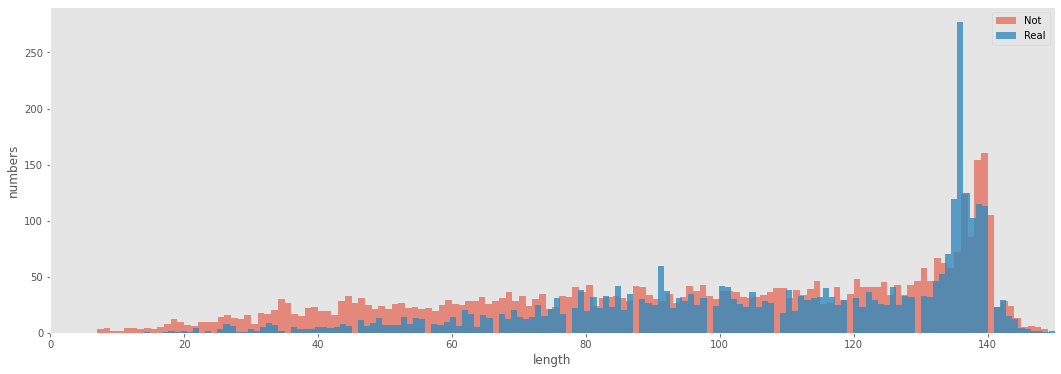

In [17]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
bins = 150
plt.hist(tweet[tweet['target'] == 0]['length'], alpha = 0.6, bins=bins, label='Not')
plt.hist(tweet[tweet['target'] == 1]['length'], alpha = 0.8, bins=bins, label='Real')
plt.xlabel('length')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0,150)
plt.grid()
plt.show()

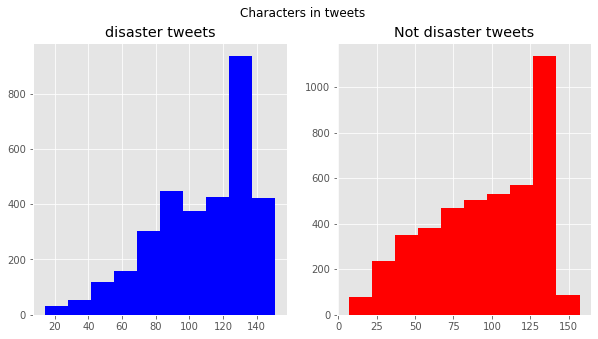

In [18]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=tweet[tweet['target']==1]['text'].str.len()
ax1.hist(tweet_len,color='blue')
ax1.set_title('disaster tweets')
tweet_len=tweet[tweet['target']==0]['text'].str.len()
ax2.hist(tweet_len,color='red')
ax2.set_title('Not disaster tweets')
fig.suptitle('Characters in tweets')
plt.show()

The distribution of both seems to be almost same 120 to 140 characters in a tweet are the most common among both.

<b> Number of words in a tweet </b>


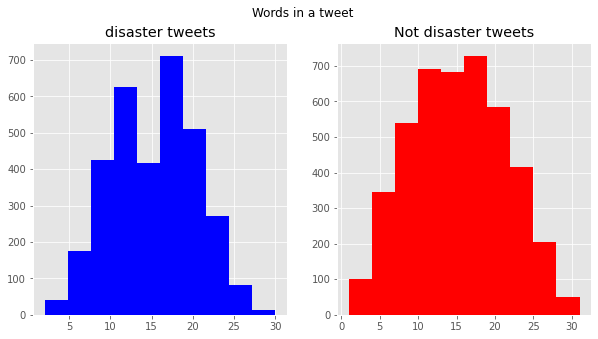

In [19]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=tweet[tweet['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='blue')
ax1.set_title('disaster tweets')
tweet_len=tweet[tweet['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='red')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()

<b> Average word length in a tweet </b>


0                [3, 5, 3, 3, 6, 2, 4, 11, 3, 5, 7, 2, 3]
1                                   [6, 4, 4, 2, 5, 5, 6]
2       [3, 9, 5, 2, 8, 2, 6, 3, 5, 8, 2, 9, 2, 5, 10,...
3                             [6, 6, 7, 10, 10, 6, 2, 10]
4       [4, 3, 4, 4, 5, 4, 4, 7, 2, 5, 4, 10, 5, 4, 1, 6]
                              ...                        
7608                   [3, 5, 6, 7, 1, 6, 8, 4, 6, 5, 22]
7609    [12, 12, 3, 3, 2, 7, 4, 5, 2, 10, 4, 2, 3, 8, ...
7610                            [5, 6, 8, 1, 2, 7, 7, 22]
7611    [6, 13, 5, 2, 6, 8, 4, 1, 3, 2, 6, 9, 6, 5, 8,...
7612            [3, 7, 4, 5, 5, 2, 8, 10, 8, 1, 3, 4, 22]
Name: text, Length: 3271, dtype: object


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0.98, 'Average word length in each tweet')

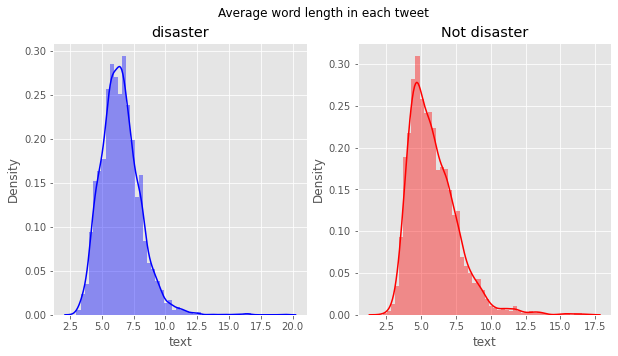

In [24]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
word=tweet[tweet['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
print(word)
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1, color='blue')
ax1.set_title('disaster')
word=tweet[tweet['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2, color='red')
ax2.set_title('Not disaster')
fig.suptitle('Average word length in each tweet')